In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [2]:
data = pd.read_csv('sparkplug_final_faults.csv')
df = pd.DataFrame(data)

In [3]:
df.head()

,CylinderPressure[PSI],AirFuelRatio[AFR],SparkGap[mm],SparkDuration[ms],CombustionTemp[°C],IgnitionTiming[°BTDC],VoltageSupply[Volts],EngineRPM[Speed],PlugAge[Years],SparkPlugPerformance
0,167.591183,13.688322,1.078109,2.086483,644.241636,21.496368,12.781978,5389.444951,3.569874,97.151834
1,156.282551,13.338097,0.836346,2.243827,786.441784,20.263661,12.516820,3137.637919,1.987942,66.094402
2,176.137322,14.147762,0.982744,1.946142,667.066917,22.038822,12.277144,3213.091509,3.378798,90.958379
3,165.414077,13.670408,0.959122,1.799335,620.037964,20.364847,13.548930,4116.272667,2.911240,74.642433
4,180.745682,13.598172,1.053716,1.438579,616.418899,28.559487,12.300458,5411.865721,3.286322,99.978033


In [4]:
df.tail()

,CylinderPressure[PSI],AirFuelRatio[AFR],SparkGap[mm],SparkDuration[ms],CombustionTemp[°C],IgnitionTiming[°BTDC],VoltageSupply[Volts],EngineRPM[Speed],PlugAge[Years],SparkPlugPerformance
219995,149.301229,14.050091,0.812995,1.351864,803.120429,14.251226,13.197677,2160.595872,1.544892,54.251402
219996,153.940963,13.833636,0.882329,1.983212,583.252344,23.728827,12.324125,4426.839289,2.547863,80.243106
219997,161.797122,13.752172,0.869954,1.771923,579.687072,20.095432,13.098309,3264.675262,1.936638,68.704067
219998,160.239597,13.516695,0.945978,1.521969,675.300481,25.099079,11.638456,3744.817353,2.686097,93.297079
219999,140.718821,13.949719,0.821706,1.954300,793.594457,10.711003,13.194025,2596.597035,1.736742,51.887264


In [5]:
df.shape

(220000, 10)

In [6]:
df.isnull().sum()

CylinderPressure[PSI]    0
AirFuelRatio[AFR]        0
SparkGap[mm]             0
SparkDuration[ms]        0
CombustionTemp[°C]       0
IgnitionTiming[°BTDC]    0
VoltageSupply[Volts]     0
EngineRPM[Speed]         0
PlugAge[Years]           0
SparkPlugPerformance     0
dtype: int64

In [7]:
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

In [8]:
X = pd.DataFrame(X)

In [9]:
corr_matrix = X.corr().abs()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
drop_cols = [column for column in upper_tri.columns if any(upper_tri[column] > 0.9)]
X = X.drop(columns=drop_cols)

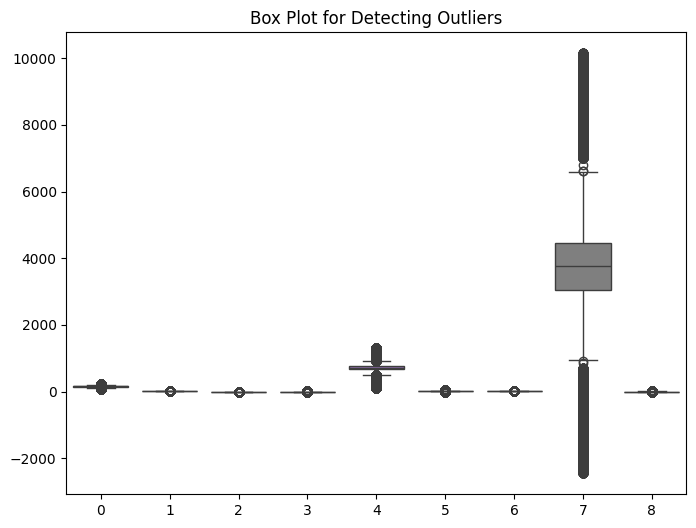

In [10]:
plt.figure(figsize=(8,6))
sns.boxplot(data=X)
plt.title('Box Plot for Detecting Outliers')
plt.show()

In [11]:
Q1 = np.percentile(X, 25, axis = 0)
Q3 = np.percentile(X, 75, axis = 0)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
mask = (X >= lower_bound) & (X <= upper_bound)
filtered_indices = np.all(mask, axis=1)

X_filtered = X[filtered_indices]
y_filtered = y[filtered_indices]

print('Outliers removed. New Dataset shape: ', X_filtered.shape)

Outliers removed. New Dataset shape:  (198028, 9)


In [12]:
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X_filtered)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_filtered, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [14]:
xgb_model = XGBRegressor(
    objective='reg:squarederror', 
    n_estimators=500, 
    learning_rate=0.05, 
    max_depth=6, 
    subsample=0.8, 
    colsample_bytree=0.8, 
    random_state=42)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [15]:
y_pred = xgb_model.predict(X_test)

In [16]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('Mean Squared Error (MSE): ', mse)
print('Mean Absolute Error (MAE): ', mae)
print('R-Squared (R2): ', r2)

Mean Squared Error (MSE):  15.54205810407795
Mean Absolute Error (MAE):  3.127820639523713
R-Squared (R2):  0.9250140004070435


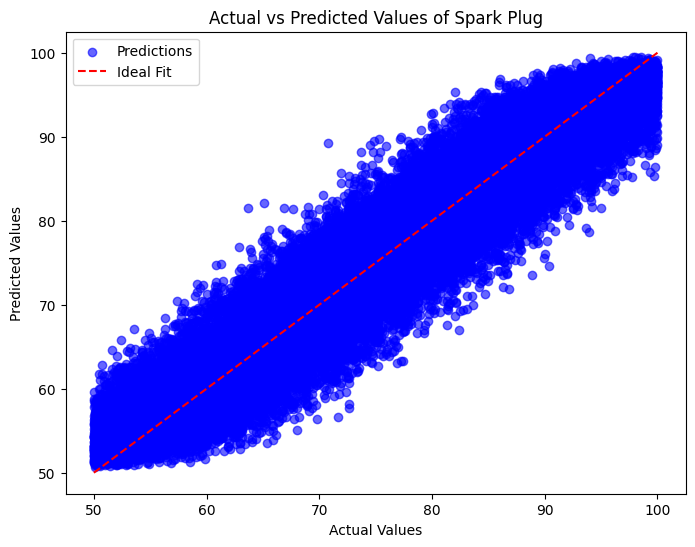

In [17]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color = 'blue', alpha = 0.6, label = 'Predictions')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color = 'red', linestyle = '--', label = 'Ideal Fit')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values of Spark Plug')
plt.legend()
plt.show()